In [1]:
import pydpmd as dp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import numpy as np
import h5py
from tqdm import tqdm
from pydpmd.plot import draw_particles_frame, draw_circle
from system_building_resources import *


def my_fit_left(x, y, n_x_grids=100, xc_min=None, xc_max=None, tail_length=None, min_points=10):
    if xc_min is None:
        xc_min = x.max() * 0.9
    if xc_max is None:
        xc_max = x.max() * 1.1
    if tail_length is None:
        tail_length = x.size

    x_grid = np.linspace(xc_min, xc_max, n_x_grids)

    errors = []
    for xc in x_grid:
        delta = np.log10(xc - x)
        f = np.log10(y)
        mask = ~(np.isnan(f) | np.isnan(delta))
        if np.sum(mask) < min_points:
            sse = np.inf
        else:
            m, b = np.polyfit(delta[mask], f[mask], 1)
            sse = np.sum((m * delta[mask][:tail_length] + b - f[mask][:tail_length]) ** 2)
        errors.append(sse)

    xc = x_grid[np.argmin(errors)]
    delta = np.log10(xc - x)
    f = np.log10(y)
    mask = ~(np.isnan(f) | np.isnan(delta))
    m, b = np.polyfit(delta[mask], f[mask], 1)

    return {
        'xc': xc,
        'sse': min(errors),
        'A': 10 ** b,
        'n': m
    }

In [2]:
root = '/home/mmccraw/dev/data/11-06-25/pressure-loop/log/'

lowest_phi = np.inf
lowest = None

phi = []
pressure = []
nv = []
mu = []

for fname in os.listdir(root):
    try:
        data = dp.data.load(os.path.join(root, fname), location=['final', 'init'], load_trajectory=True)
        data.calculate_mu_eff()
        # plt.scatter(data.delta_phi[0], np.mean(data.trajectory.pressure, axis=0)[0])
        if data.packing_fraction[0] < lowest_phi:
            lowest_phi = data.packing_fraction[0]
            lowest = data
        # plt.plot(data.trajectory.pressure[:, 1])
        # plt.scatter(data.delta_phi, np.mean(data.trajectory.pressure, axis=0), c=data.n_vertices_per_particle[data.system_offset[:-1]])
        # plt.scatter(data.packing_fraction, np.mean(data.trajectory.pressure, axis=0), c=data.n_vertices_per_particle[data.system_offset[:-1]])
        # plt.scatter(data.delta_phi, np.mean(data.trajectory.pressure, axis=0), c=data.mu_eff[data.system_offset[:-1]])
        # plt.scatter(data.packing_fraction, np.mean(data.trajectory.pressure, axis=0), c=data.mu_eff[data.system_offset[:-1]])
        mu.extend(data.mu_eff[data.system_offset[:-1]])
        nv.extend(data.n_vertices_per_particle[data.system_offset[:-1]])
        pressure.extend(np.mean(data.trajectory.pressure, axis=0))
        phi.extend(data.packing_fraction)
    except:
        pass

df = pd.DataFrame({'nv': nv, 'mu': mu, 'p': pressure, 'phi': phi})

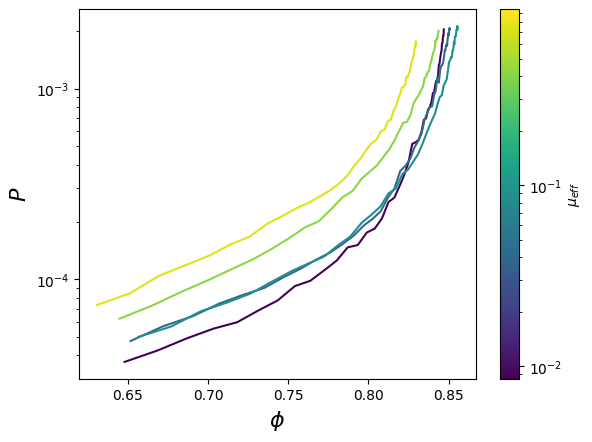

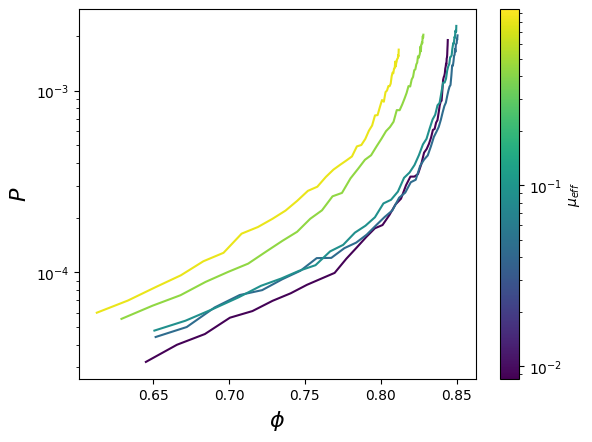

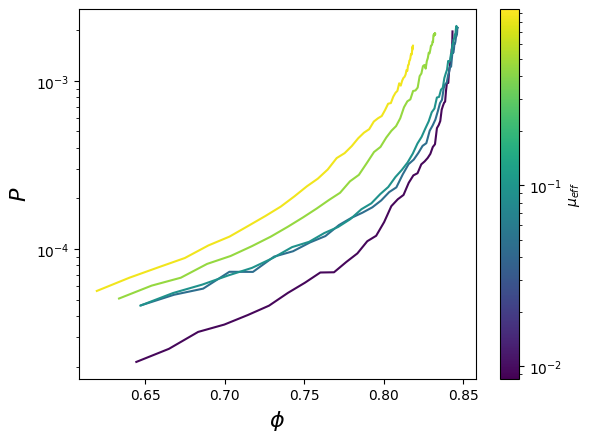

In [ ]:
mu_norm = LogNorm(vmin=np.min(df.mu), vmax=np.max(df.mu))
cmap = plt.cm.viridis

fits = {
    'nv': [],
    'mu': [],
    'phi_c': [],
    'n': []
}

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        mask = (df.mu == mu) & (df.nv == nv)
        _df = df[mask]
        phi = _df.phi.values
        p = _df.p.values
        p = p[np.argsort(phi)]
        phi = phi[np.argsort(phi)]

        fit = my_fit_left(phi, p, xc_min=phi.max() * 1.0001, xc_max=phi.max() * 1.1)
        # xc_min=0.98 * x.max(), xc_max=1.1 * x.max(), tail_length=10, min_points=10)

        # plt.plot(fit['xc'] - phi, p, c=cmap(mu_norm(mu)))
        # plt.plot(fit['xc'] - phi, fit['A'] * np.abs(fit['xc'] - phi) ** fit['n'], c=cmap(mu_norm(mu)), linestyle='--')

        B = -fit['A'] * fit['n'] * np.abs(fit['xc'] - phi) ** (fit['n'] - 1)
        # plt.plot(phi, B, c=cmap(mu_norm(mu)))
        plt.plot(phi, p, c=cmap(mu_norm(mu)))

        fits['nv'].append(nv)
        fits['mu'].append(mu)
        fits['phi_c'].append(fit['xc'])
        fits['n'].append(fit['n'])

        # plt.plot(phi[-1] - phi + 1e-3, p, c=cmap(mu_norm(mu)))
        # plt.plot(phi, p, c=cmap(mu_norm(mu)))
    x = np.logspace(-3, -1, 10)
    # plt.plot(x, 1e-6/x)
    # plt.plot(x, 1e-4/x ** 0.5)
    # plt.xscale('log')
    plt.yscale('log')

    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.abs(df.mu))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')

    plt.xlabel(r'$\phi$', fontsize=16)
    plt.ylabel(r'$P$', fontsize=16)

    plt.show()

fits = pd.DataFrame(fits)

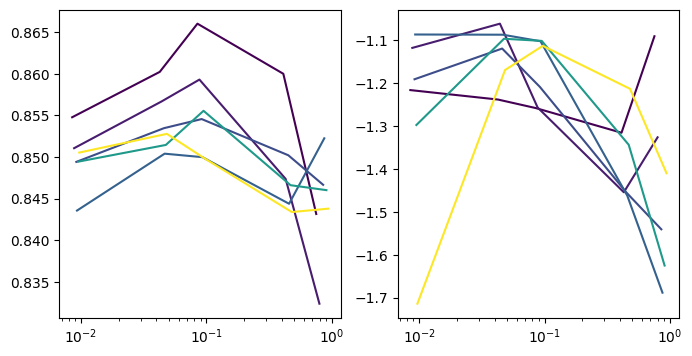

In [4]:
nv_norm = plt.Normalize(vmin=min(fits.nv), vmax=max(fits.nv))

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for nv in np.unique(fits.nv):
    _df = fits[fits.nv == nv]
    axs[0].plot(_df.mu, _df.phi_c, c=cmap(nv_norm(nv)))
    axs[1].plot(_df.mu, _df.n, c=cmap(nv_norm(nv)))
for a in axs:
    a.set_xscale('log')

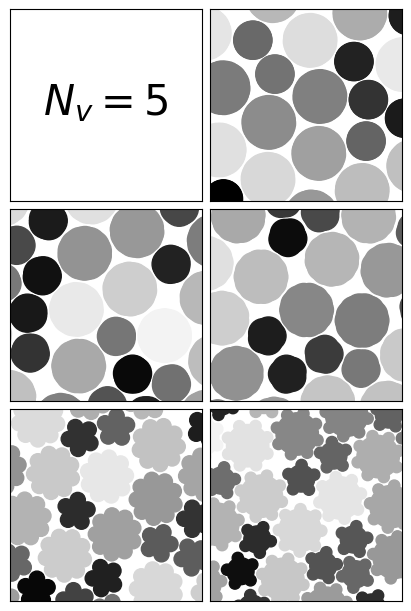

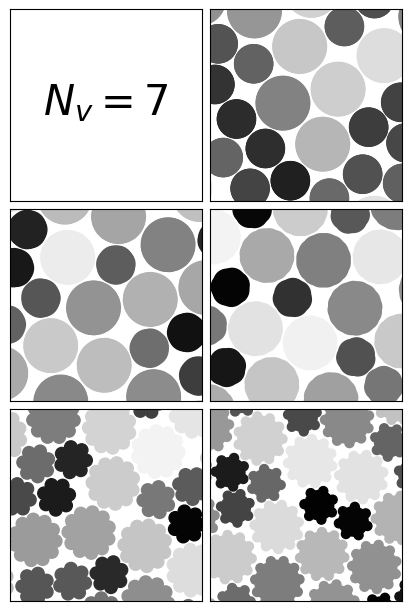

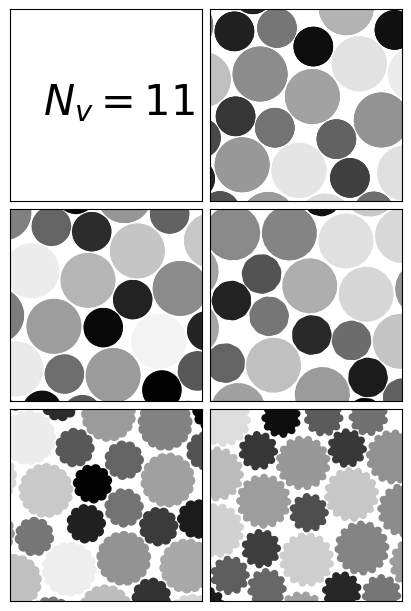

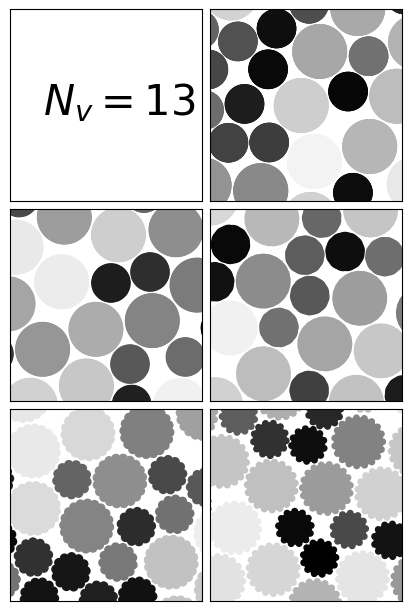

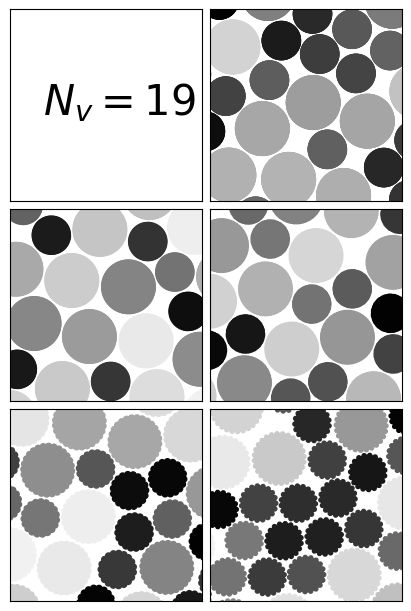

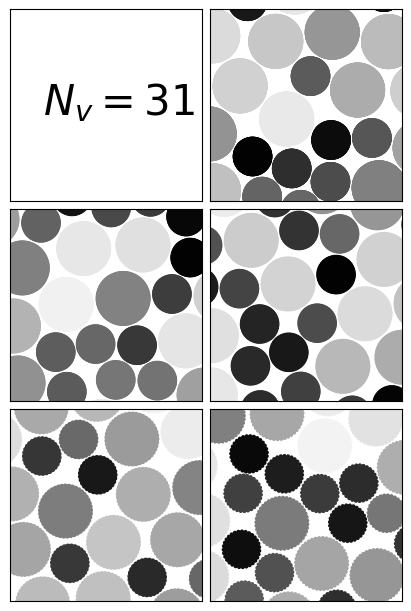

In [ ]:
data.scale_to_packing_fraction(data.packing_fraction - 0.1)

data.calculate_mu_eff()
nv = data.n_vertices_per_particle[data.system_offset[:-1]] - 1
mu = data.mu_eff[data.system_offset[:-1]]

for _nv in np.unique(nv):
    mu_list = np.sort(mu[nv == _nv])
    fig, ax = plt.subplots(3, 2, figsize=(4, 6), constrained_layout=True)
    for a in ax.ravel():
        a.set_aspect('equal')
        a.set_xticks([])
        a.set_yticks([])
    for d in split_systems(data):
        if d.n_vertices_per_particle[0] - 1 == _nv:
            a = ax.ravel()[mu_list.tolist().index(d.mu_eff[0]) + 1]
            draw_particles_frame(None, a, d, 0, True, 'vertex', 'grey', None, 1.05)
            l = 5
            a.set_xlim(d.box_size[0, 0] / 2, d.box_size[0, 0] / 2 + l)
            a.set_ylim(d.box_size[0, 1] / 2, d.box_size[0, 1] / 2 + l)
            a.set_title(None)
    ax[0, 0].text(0.17, 0.45, rf'$N_v=${_nv}', fontsize=30)
    # plt.savefig(f'particle-figures/NV-{_nv}.png', dpi=600)
    plt.show()